<a href="https://colab.research.google.com/github/Zahidlab/Pytorch-Practice/blob/main/PyTorch_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
trans = transforms.ToTensor()

mnist_data = datasets.MNIST(root = './data', train = True, transform = trans, download = True)

data_loader = torch.utils.data.DataLoader(dataset = mnist_data, batch_size = 64, shuffle = True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
from torchvision.utils import make_grid
def show_batch(dl, nmax=64, torch_tensor = True):
  
  if torch_tensor:
    images= dl
  else:
    images, _ = next(iter(dl))
    
  # images = to_device(images, "cpu")
  fig,ax = plt.subplots(figsize = (8,8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid( 
      images[:nmax], nrow = 8).permute(1,2,0)
      
  )

## Image Details

Batch Size = 64
Channels = 1
Height X Width = 28 X 28
Minimum Pixel Value = 0.0
Maximum Pixel Value: 1.0


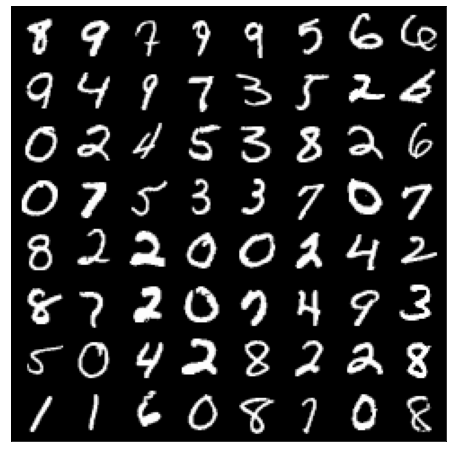

In [5]:
images, labels = next(iter(data_loader))

print(f"Batch Size = {images.shape[0]}\nChannels = {images.shape[1]}\nHeight X Width = {images.shape[2]} X {images.shape[3]}")
print(f"Minimum Pixel Value = {torch.min(images)}\nMaximum Pixel Value: {torch.max(images)}")
show_batch(data_loader, torch_tensor = False)

# Linear AutoEncoder Class

In [ ]:
class AutoEncoder_Linear(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        
        nn.Linear(28*28, 128),    #N, 784
        nn.ReLU(),

        nn.Linear(128, 64),
        nn.ReLU(),

        nn.Linear(64, 12),
        nn.ReLU(),

        nn.Linear(12, 3),   #N, 3
   
 
    )

    self.decoder = nn.Sequential(
        
        nn.Linear(3, 12),    #N, 3
        nn.ReLU(),

        nn.Linear(12, 64),
        nn.ReLU(),

        nn.Linear(64, 128),
        nn.ReLU(),

        nn.Linear(128, 28*28),   #N, 784

        nn.Sigmoid()
    )



  def forward(self, x):
    encoded = self.encoder(x)
    # print(f"Shape of encoded: {encoded.shape}")
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder_Linear()
EPOCHS = 1
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)


In [ ]:
outputs = []
for epoch in range(EPOCHS):

  for (img, _) in data_loader:
    img = img.reshape(-1, 28*28)

    # print(img.shape)
    result = model(img)
    print(f"img shape: {img.shape}")
    print(f"pred shape: {result.shape}")
    loss = loss_fn(result, img)

    optim.zero_grad()
    loss.backward()
    optim.step()

  
  print(f"Epoch: {epoch+1} | Loss: {loss.item():.4f}")
  outputs.append((epoch, img, result))

# print(f"img shape: {result.shape}")
# print(f"pred shape: {result.shape}")

Black: \u001b[30m
Red: \u001b[31m
Green: \u001b[32m
Yellow: \u001b[33m
Blue: \u001b[34m
Magenta: \u001b[35m
Cyan: \u001b[36m
White: \u001b[37m
Reset: \u001b[0m

In [ ]:
images= outputs[0][2]
images = images.reshape(-1,1, 28,28)
images.shape

In [ ]:
with torch.inference_mode():
  grid = make_grid(images, nrow = 8)

# grid.shape
# plt.imshow(grid.permute(1,2,0))

fig,ax = plt.subplots(figsize = (18,18))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow( grid.permute(1,2,0))



# Autoencoder CNN


In [46]:
class AutoEncoder_CNN(nn.Module):

  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        
        nn.Conv2d(1, 16, 3, 2,1),    #N, 16, 14, 14 
        nn.ReLU(),

        nn.Conv2d(16, 32, 3, 2,1),      #N, 32, 7, 7 
        nn.ReLU(),

        nn.Conv2d(32, 64, 7),  #N, 64, 1, 1

 
    )


    self.decoder = nn.Sequential(
        
        nn.ConvTranspose2d(64, 32, 7),    #N, 32, 7, 7
        nn.ReLU(),

        nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),   #N, 16, 14, 14
        nn.ReLU(),

        nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding = 1),   #N, 1, 28, 28


        nn.Sigmoid()
    )



  def forward(self, x):
    encoded = self.encoder(x)
    # print(f"Shape of encoded: {encoded.shape}")
    decoded = self.decoder(encoded)
    return decoded

In [47]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()        
    # N, 1, 28, 28
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
    )
    
    # N , 64, 1, 1
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
        nn.Sigmoid()
    )

  def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [48]:
model = AutoEncoder_CNN()
EPOCHS = 5
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)

In [49]:
outputs = []
for epoch in range(EPOCHS):

  for (img, _) in data_loader:
    # img = img.reshape(-1, 28*28)

    # print(img.shape)
    result = model(img)
    # print(f"img shape: {img.shape}")
    # print(f"pred shape: {result.shape}")
    loss = loss_fn(result, img)

    optim.zero_grad()
    loss.backward()
    optim.step()

  
  print(f"\u001b[31mEpoch: {epoch+1} | Loss: {loss.item():.4f}")
  outputs.append((epoch, img, result))

# print(f"img shape: {result.shape}")
# print(f"pred shape: {result.shape}")

Epoch: 1 | Loss: 0.0096
Epoch: 2 | Loss: 0.0052
Epoch: 3 | Loss: 0.0041
Epoch: 4 | Loss: 0.0035
Epoch: 5 | Loss: 0.0028


In [50]:
images= outputs[4][1]
images.shape

torch.Size([32, 1, 28, 28])

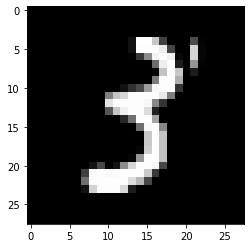

In [51]:
with torch.inference_mode():
  plt.imshow(images[0].squeeze(), cmap = 'gray')

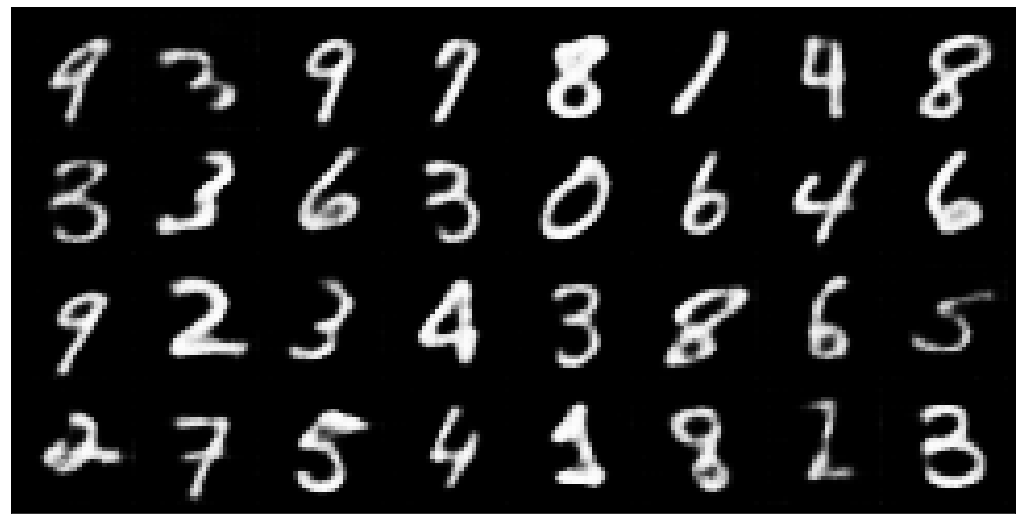

In [52]:
images= outputs[0][2]
images = images.reshape(-1,1, 28,28)
images.shape

with torch.inference_mode():
  grid = make_grid(images, nrow = 8)

# grid.shape
# plt.imshow(grid.permute(1,2,0))

fig,ax = plt.subplots(figsize = (18,18))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow( grid.permute(1,2,0))

[Tutorial Link](https://www.youtube.com/watch?v=zp8clK9yCro)